<a href="https://colab.research.google.com/github/dasjyotishka/Understanding-Koopman-decomposition-and-Duffing-oscillator/blob/main/TP5_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Koopman decomposition, a toy case: Duffing oscillator


The aim of this notebook is to describe the dynamics of a non-linear dynamical system by means of the Koopman theory.

## Introduction

We consider a quantity $x$ (a vector) which evolves with time, following a dynamical system. Think for example of the joint location of the planets in our solar system, which follows the law of gravitation.

Formally, given an initial state $x(t=0) \in \mathbb{R}^n$ at time $t=0$, the time evolution of $x$ is governed by the following dynamical system:
$$
\dot{x(t)} = f(x(t)) \quad \text(1)
$$

where $\dot{x(t)} := {dx}/{dt}$ is the temporal derivative, and $f:\mathbb{R}^n \rightarrow \mathbb{R}^n$ is a given map describing the dynamics.

For a given $f$, it is not always possible to solve the differential equation (1) analytically. For this reason, instead, numerical schemes are usually employed, to integrate in time $t$ (and space $\Omega$ if needed) the eq (1), so as to propagate the initial condition $x(0)$ up to a desired time $T$; think of $x(T) = x(0) + \int_{t=0}^{T} f(x(t)) dt$. The discretization in time of eq (1) or of the integral introduces numerical approximations, and yields estimates of $x(T)$ of various quality depending on the discretization scheme.

In the field of numerical simulations, discretization schemes have been studied for a long time, and numerical solvers already exist to provide good estimates of integrals (far better than with the naive discretization $x_{t+dt} = x_t + dt\,f(x_t)$, which induces a $O(dt^2)$ error at each time step).

The goal of this practical session is to make use of such numerical solvers to improve the learning of dynamical systems with neural networks.

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm


## Duffing oscillator

As a toy example, we consider the Duffing oscillator, where the state $x = (x_1, x_2) \in \mathbb{R}^2$ follows the dynamical system described by the following ODEs:

$$
\dot{x}_1 = x_2\\
\dot{x}_2 = x_1 - x_1^3
$$

To integrate in time the ODEs, a 4th order Runge-Kutta scheme can be used.


In [ ]:
def duffing(t, x : np.ndarray) -> np.ndarray:
    dx = np.zeros(x.shape)
    dx[0] = x[1]
    dx[1] = x[0] -x[0]**3
    return dx

In [ ]:
tmax = 500    #time-horizon integration
niter = 5000  #number of time steps integration
Ninit = 60    #number of initial conditions

X0 = (np.random.rand(Ninit,2)-0.5)*4
t = np.linspace(0, tmax, niter)
Xt = np.zeros((X0.shape[0],X0.shape[1],niter))
for i in tqdm(range(X0.shape[0])):
    f = solve_ivp(duffing, [0,tmax], X0[i], method='RK45',t_eval=t)
    Xt[i,:] = f.y

100%|██████████| 60/60 [00:15<00:00,  3.95it/s]


The following plot shows trajectories for different initial conditions:

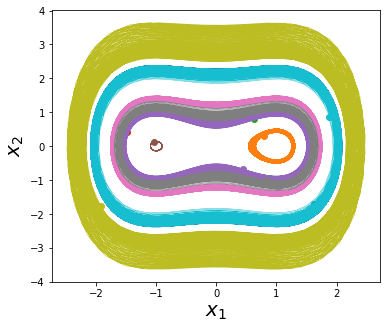

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131)
cm = plt.get_cmap("tab10")
print(cm)
for i in range(10):
    ax.plot(Xt[i,0,:], Xt[i,1,:],lw=0.5, color=cm(i))
    ax.plot(Xt[i,0,0], Xt[i,1,0],'o',lw=1.5, color=cm(i)) #initial condition
ax.set_xlabel('$x_1$', fontsize = 20)
ax.set_ylabel('$x_2$', fontsize = 20)
plt.show()

## The Koopman operator
### Discontinuous in time case
Given the discrete non-linear dynamical system

$$
x_{t+1} = \mathbf{F}(x_t)
$$

where $\mathbf{F}$ might be the flow map of the continuous dynamical system in eq (1) and $X = \{x_t | t = 1 \ldots N \}$ the time series of the system state.

$$
\mathbf{F}(x(t_0)) = x(t_0) + \int_{t_0}^{t_0+ t} f(x(\tau))d\tau
$$

the Koopman theory states that there exists an infinite-dimensional linear operator $\mathcal{K}$ that advances in time all observable functions $g_i: \mathbb{R}^n \rightarrow \mathbb{R}$

$$
\mathcal{K} g_i(x) = g_i \circ \mathbf{F}(x).
$$

This way, the non-linear dynamics of $x$, described by $\mathbf{F}$, can be turned into a **linear** dynamical system, described by $\mathcal{K}$, acting on another representation space, formed by the observable quantities $g_i(x)$.

It is then sufficient to find a function $g: \mathbb{R}^n \rightarrow \mathbb{R}^m$ with $m \gg n$ that embeds the state $x$ into a "larger enough" dimensional space $m$ such that the linear operator $\mathcal{K}$ can be inferred by a matrix $\mathbf{K} \in \mathbb{R}^{m \times m}$.

To project back the dynamics from the Koopman space ($\mathbb{R}^m$, where $g(x)$ lives) to the phase space ($\mathbb{R}^n$, where $x$ lives), a supplementary function $\varphi: \mathbb{R}^m \rightarrow \mathbb{R}^n$ is needed. Going from $x$ to the Koopman space and back yields $\varphi \text{ o  } g = $ Id.

Under this condition, the functions $g$, $\varphi$ and $\mathbf{K}$ can be parametrized $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{K}_{\phi}$, and the parameters $\theta$, $\rho$ and $\phi$ can be learned minimizing suitable loss functions.

For this purpose, given a time series $X = \{x_t | t = 1 \ldots N \}$, the following conditions hold:


1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x_t)) - x_t  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{K_{\phi}} g_{\theta} ( x_t ) - g_{\theta} (x_{t+1})  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_t )\right) - x_{t+1} \Vert = 0
     $$

The last three errors can be used as loss functions to train three different neural networks. These different neural networks compose our architecture that can be summarized as in the following sketch:



![architecture](./architecture.png)

In [ ]:
# arrange the dataset
from sklearn.model_selection import train_test_split
X = np.transpose(np.concatenate([Xt[i,:,:-1] for i in range(Xt.shape[0])], axis=1))
Y = np.transpose(np.concatenate([Xt[i,:,1:] for i in range(Xt.shape[0])], axis=1))

X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.2)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.utils.data import DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')

batch_size = 2000     # data per batch

training_data = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(Y_test))

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# create the models
feature_dim = 2       # dimension of the Duffing oscillator
hidden_layer = 5      # number of hidden layers in g (ENCODER) and \varphi (DECODER)
output_dim = 30       # dimension in Koopman space

In [ ]:
class encoder(nn.Module):
    def __init__(self, layer_dim):
        super(encoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i+1]))

    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)


In [ ]:
class decoder(nn.Module):
    def __init__(self, layer_dim):
        super(decoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1,0,-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i-1]))

    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [ ]:
class autoencoder(nn.Module):
    def __init__(self,feature_dim, hidden_layer, output_dim):
        super(autoencoder, self).__init__()
        layer_dim = [output_dim if i == hidden_layer else feature_dim+i*(output_dim-feature_dim)//hidden_layer for i in range(hidden_layer+1)]
        self.encoder = encoder(layer_dim)
        self.decoder = decoder(layer_dim)
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)

The Koopman operator $\mathbf{K}$ (which is linear, and thus a matrix) must have a spectral radius $\rho(\mathbf{K})\le 1$. Such condition will provide a stable -or at least a marginally stable- Koopman operator. To fulfill this requirement, we might leverage on the Perron-Frobenius theorem.

The Perron-Frobenius th. states: if $\mathbf{K}$ is a $m \times m$ positive matrix i.e. $k_{ij} > 0$ for $1 \le i,j \le m$, then the following inequality holds:

$$
\min_i \sum_j k_{ij} \le \rho(\mathbf{K}) \le \max_i \sum_j k_{ij}
$$


**Question 1.** : Complete the `KoopmanModule` class to enforce $\rho(\mathbf{K})\le 1$, making use of the Perron-Frobenius theorem. Check that the initialization fulfills this property.

In [ ]:
import sys

class KoopmanModule(nn.Module):
    #A linear transformation on a tensor of shape (batch_size, input_dim) is implemented, where input_dim is the number of input features.
    #This linear transformation is the Koopman operator, which is represented by a weight matrix of size (output_dim, output_dim).
    def __init__(self, output_dim):

        super().__init__()

        #The weight matrix is initialized as a random matrix of size (output_dim, output_dim).
        self.output_dim = output_dim
        self.weight = torch.randn(output_dim, output_dim)

        #The largest eigenvalue of the weight matrix is computed.
        #The weight matrix is normalized by dividing it by the absolute value of the largest eigenvalue.
        eigenvalues, _ = torch.linalg.eig(self.weight)
        max_eigenvalue = torch.max(torch.abs(eigenvalues))
        self.weight = self.weight / max_eigenvalue

        #Set the weight matrix to be the normalized matrix.
        #The normalized weight matrix is then stored as a PyTorch parameter.
        self.weight = nn.Parameter(self.weight, requires_grad=True)

    def forward(self, X):

        #If the number of input features in the input tensor X does not match the input_dim parameter of the module, an error message is printed and the program exits.
        #This ensures that the input tensor has the correct shape before applying the Koopman operator.
        x, y = X.shape
        if y != self.output_dim:
            sys.exit(f'Wrong Input Features. Please use tensor with {self.output_dim} Input Features')


        # The input tensor X is multiplied by the normalized weight matrix to compute the Koopman operator for the given input.
        X_k = torch.matmul(X, self.weight)

        return X_k




In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
AUTOENCODER = autoencoder(feature_dim, hidden_layer, output_dim).to(device)
KPM = KoopmanModule(output_dim).to(device)
print(AUTOENCODER)




autoencoder(
  (encoder): encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


In [ ]:
opt_aut = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.0001)
opt_kpm = torch.optim.Adam(KPM.parameters(), lr=0.00001)

**Question 2.** : Define a function to compute the loss to be minimized. It should at least include the 3 terms listed above:
- Reconstruction error
- Prediction error in the Koopman space
- Prediction error in the phase space

Because the different objectives outlined by these losses may compete, the training can be difficult. You may try different variations on these losses and comment your findings. In order to improve the training process, one can for instance:
- Add a multiplicative factor in front of each loss component, to balance their importance; how the scales of different losses are related?
- We can refine the loss acting upon the latent space, by using a variational autoencoder approach. This is similar to the Gaussian likelihood used in the first practical (TD1). We want the prediction in the latent space (i.e. the Koopman space) to be a normal distribution $\mathcal{N}(0, 1)$ . Add a corresponding loss for the latent space. Difference to 0 mean and 1 standard deviation must be thus included in the loss;
- Freeze the gradients of one part of the network, for instance the encoder, for one specific objective, using the [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) property. For instance:
```python
criterion = nn.MSELoss()
...
# Compute one part loss_l of the total loss
# First deactivate gradient computation for irrelevant parts of the architecture
for p in AUTOENCODER.encoder.parameters():
    p.requires_grad = False
loss_l = criterion(pred, target)
# Restore the gradient computation
for p in AUTOENCODER.encoder.parameters():
    p.requires_grad = True
...
total_loss = loss_1 + ... + loss_l + ...
return total_loss
```

## Using multiplicative factors to scale different losses

In [ ]:
# Defining the hyperparameters that control the relative importance of each loss component inside the loss function
def LOSS(X, Y, X_recon, gX, gY, gY_pred, Y_pred, alpha=0.9, beta=1, gamma=0.9, delta=0.3):
    loss1 = torch.mean(torch.pow((X_recon - X), 2)) #Reconstruction loss
    loss2 = torch.mean(torch.pow((gX - gY), 2))#Koopman prediction loss1
    loss3 = torch.mean(torch.pow((gY_pred - gY), 2))#Koopman prediction loss2
    loss4 = torch.mean(torch.pow((Y_pred - Y), 2))#Phase prediction loss
    output = alpha*loss1 + beta*loss2 + gamma*loss3 + delta*loss4
    return output, loss1, loss2, loss3, loss4



The following cell executes the training loop. You can modify it in order to display the different intermediate losses computed in the function `LOSS` above. How do they evolve in time? Justify your final choice.

In [ ]:
def training():
    for epoch in range(41):
        AUTOENCODER.train()
        KPM.train()

        total_train_loss = 0
        total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
        for X_, Y_ in train_dataloader:
            X_, Y_ = X_.to(device), Y_.to(device)

            opt_aut.zero_grad()
            opt_kpm.zero_grad()


            # gX_ = observable(X_), gY_ = observable(Y_)
            gX_ = AUTOENCODER.encoder(X_)
            gY_ = AUTOENCODER.encoder(Y_)

            # X_recon = in_observable(observable(X_))
            X_recon = AUTOENCODER.decoder(gX_)

            # gY_pred = KPM*observable(X_)
            gY_pred = KPM(gX_)

            # Y_pred = inv_observable(KPM*observable(X_))
            Y_pred = AUTOENCODER.decoder(gY_pred)

            output, loss1, loss2, loss3, loss4 = LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred)
            output.backward()
            opt_aut.step()
            opt_kpm.step()

            total_train_loss += output.item()/X_.size(0)/len(train_dataloader)
            total_loss1 += loss1.item()/X_.size(0)/len(train_dataloader)
            total_loss2 += loss2.item()/X_.size(0)/len(train_dataloader)
            total_loss3 += loss3.item()/X_.size(0)/len(train_dataloader)
            total_loss4 += loss4.item()/X_.size(0)/len(train_dataloader)


            #total_loss2 += loss2.item()/X_.size(0)/len(train_dataloader)
            #total_loss3 += loss3.item()/X_.size(0)/len(train_dataloader)
            #total_loss4 += loss4.item()/X_.size(0)/len(train_dataloader)

        if epoch%1 == 0:
           print(epoch, total_train_loss, total_loss1, total_loss2, total_loss3, total_loss4)

        if epoch%10 == 0:
            AUTOENCODER.eval()
            KPM.eval()
            with torch.no_grad():
                total_test_loss = 0
                for X_, Y_ in test_dataloader:
                    X_, Y_ = X_.to(device), Y_.to(device)

                    gX_ = AUTOENCODER.encoder(X_)
                    gY_ = AUTOENCODER.encoder(Y_)
                    X_recon = AUTOENCODER.decoder(gY_)
                    gY_pred = KPM(gX_)
                    Y_pred = AUTOENCODER.decoder(gY_pred)

                    output, loss1, loss2, loss3, loss4 = LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred)
                    total_test_loss += output.item()/X_.size(0)/len(test_dataloader)
                print('-'*50, 'TEST', '-'*50)
                print(epoch, total_test_loss)
                if (epoch != 0):
                    epoch_list.append(epoch)
                    test_loss.append(total_test_loss)

                print('-'*106)


In [ ]:
test_loss=[]
epoch_list=[]
training()

0 0.0009851451351256054 0.0008068590617679196 2.0521506143805536e-08 1.7239545145489675e-05 0.0008114528913246437
-------------------------------------------------- TEST --------------------------------------------------
0 0.0009648027552914155
----------------------------------------------------------------------------------------------------------
1 0.0008767175935543915 0.0007104914176913278 1.1996781087471362e-07 1.2904550767997158e-05 0.0007518041804337493
2 0.0005335561307697952 0.0004130313646066961 6.367889992777698e-07 2.491455055830443e-05 0.00046256006040672415
3 0.00044925310645490077 0.0003609851649982938 6.637933050795622e-07 1.3376325842826644e-05 0.000372213237976042
4 0.0004341446746590571 0.00035405932307643 5.445448635343772e-07 6.945110013955096e-06 0.0003623204667139199
5 0.0004177795691556834 0.00034078599572195814 4.821552245923933e-07 5.723693093633499e-06 0.0003514623133235286
6 0.00034056456390379704 0.0002664461389225087 5.645572755468871e-07 1.40932528901761

The evolution of the various intermediate test losses over epochs are printed in the logs. Now, we are printing a plot showing the evolution of the total test loss comprising of the four intermediatary losses over the number of epochs.

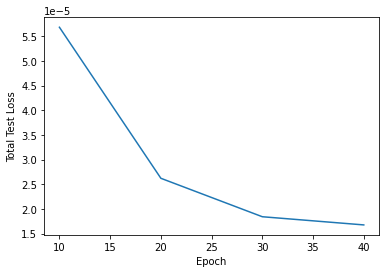

In [ ]:
# Plot to visualize the evaluation of total test loss with epochs
plt.plot(epoch_list,test_loss)
plt.ylabel('Total Test Loss')
plt.xlabel('Epoch')
plt.show()

The above plot shows that the total test loss generally decreases with the number of epochs. Therefore, our choices of hyperparameters to scale each of the losses, namely alpha = 0.9 for reconstruction loss, beta = 1.0 and gamma = 0.9 for Koopman prediction losses, and delta = 0.3 for phase prediction loss are good.

##Refining the loss acting upon the latent space, by using a variational autoencoder approach

In [ ]:
import torch
import torch.nn.functional as F

def LOSS(X, Y, X_recon, gX, gY, gY_pred, Y_pred, z_mean, z_logvar):
    # Reconstruction error
    recon_loss = F.mse_loss(X_recon, X)

    # Prediction error in the Koopman space
    gY_pred_norm = torch.norm(gY_pred, dim=1)
    gY_norm = torch.norm(gY, dim=1)
    koopman_loss = F.mse_loss(gY_pred_norm, gY_norm)

    # Prediction error in the phase space
    phase_loss = F.mse_loss(Y_pred, Y)

    # Loss for the latent space
    latent_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())

    # Total loss with hyperparameters to balance the importance of each component
    alpha = 1.0
    beta = 0.1
    gamma = 0.1
    delta = 0.1

    output = alpha * recon_loss + beta * koopman_loss + gamma * phase_loss + delta * latent_loss
    loss1 = alpha * recon_loss
    loss2 = beta * koopman_loss
    loss3 = gamma * phase_loss
    loss4 = delta * latent_loss

    return output, loss1, loss2, loss3, loss4




In [ ]:
def training_latent(z_mean, z_logvar):
    for epoch in range(101):
        AUTOENCODER.train()
        KPM.train()

        total_train_loss = 0
        total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
        for X_, Y_ in train_dataloader:
            X_, Y_ = X_.to(device), Y_.to(device)

            opt_aut.zero_grad()
            opt_kpm.zero_grad()


            # gX_ = observable(X_), gY_ = observable(Y_)
            gX_ = AUTOENCODER.encoder(X_)
            gY_ = AUTOENCODER.encoder(Y_)

            # X_recon = in_observable(observable(X_))
            X_recon = AUTOENCODER.decoder(gX_)

            # gY_pred = KPM*observable(X_)
            gY_pred = KPM(gX_)

            # Y_pred = inv_observable(KPM*observable(X_))
            Y_pred = AUTOENCODER.decoder(gY_pred)

            output, loss1, loss2, loss3, loss4 = LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred, z_mean, z_logvar)
            output.backward()
            opt_aut.step()
            opt_kpm.step()

            total_train_loss += output.item()/X_.size(0)/len(train_dataloader)
            total_loss1 += loss1.item()/X_.size(0)/len(train_dataloader)
            total_loss2 += loss2.item()/X_.size(0)/len(train_dataloader)
            total_loss3 += loss3.item()/X_.size(0)/len(train_dataloader)
            total_loss4 += loss4.item()/X_.size(0)/len(train_dataloader)


            #total_loss2 += loss2.item()/X_.size(0)/len(train_dataloader)
            #total_loss3 += loss3.item()/X_.size(0)/len(train_dataloader)
            #total_loss4 += loss4.item()/X_.size(0)/len(train_dataloader)

        if epoch%1 == 0:
           print(epoch, total_train_loss, total_loss1, total_loss2, total_loss3, total_loss4)

        if epoch%10 == 0:
            AUTOENCODER.eval()
            KPM.eval()
            with torch.no_grad():
                total_test_loss = 0
                for X_, Y_ in test_dataloader:
                    X_, Y_ = X_.to(device), Y_.to(device)

                    gX_ = AUTOENCODER.encoder(X_)
                    gY_ = AUTOENCODER.encoder(Y_)
                    X_recon = AUTOENCODER.decoder(gY_)
                    gY_pred = KPM(gX_)
                    Y_pred = AUTOENCODER.decoder(gY_pred)

                    output, loss1, loss2, loss3, loss4 = LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred, z_mean, z_logvar)

                    total_test_loss += output.item()/X_.size(0)/len(test_dataloader)
                print('-'*50, 'TEST', '-'*50)
                print(epoch, total_test_loss)
                if (epoch != 0):
                    epoch_list.append(epoch)
                    test_loss.append(total_test_loss)

                print('-'*106)


In [ ]:
test_loss=[]
epoch_list=[]
training_latent(torch.zeros(1, 10), torch.ones(1, 10))

0 0.00018047554955451865 1.1701642671113472e-07 2.6293899631832203e-07 4.883397919093752e-07 0.00017960725433958005
-------------------------------------------------- TEST --------------------------------------------------
0 0.0020374557253285608
----------------------------------------------------------------------------------------------------------
1 0.0001804453658727143 1.1452803683060452e-07 2.4575441613718595e-07 4.778290801666355e-07 0.00017960725433958005
2 0.00018041709141067966 1.1193984398315741e-07 2.2974837002878797e-07 4.6814885708785e-07 0.00017960725433958005
3 0.00018039136597515688 1.0962895582866099e-07 2.1508390125958776e-07 4.5939877848883067e-07 0.00017960725433958005
4 0.00018036749605499866 1.072916422941685e-07 2.0162974048393644e-07 4.513203326406706e-07 0.00017960725433958005
5 0.0001803432323749964 1.0447662450761635e-07 1.8916643648386435e-07 4.423349744250995e-07 0.00017960725433958005
6 0.00018032146802796333 1.0222672020006751e-07 1.7746806132364218e-07

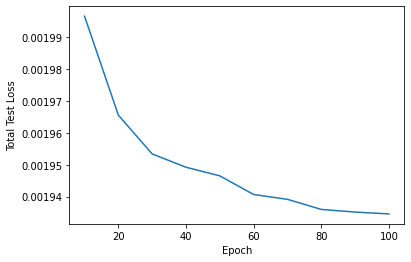

In [ ]:
# Plot to visualize the evaluation of total test loss with epochs
plt.plot(epoch_list,test_loss)
plt.ylabel('Total Test Loss')
plt.xlabel('Epoch')
plt.show()

The above plot shows that the total test loss decreases with the number of epochs. Therefore, our choices of hyperparameters to scale each of the losses, namely alpha = 1.0 for reconstruction loss, beta = 0.1 for Koopman prediction losses, gamma = 0.1 for phase prediction loss, and delta = 0.1 for loss in latent space are good selections.

#### Verification

**Question 3.** : We want to ensure the Koopman operator is stable. This can be verified by checking whether its spectral radius $\rho(\mathbf{K})\le 1$. Plot the eigenvalues of the Koopman operator in order to verify the bound on its spectral radius. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

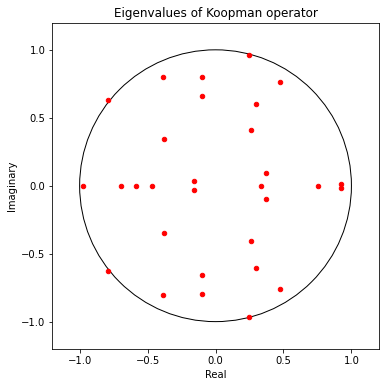

In [ ]:
# To be completed
#check Koopman stability
# Compute eigenvalues of Koopman operator
eig_vals = np.linalg.eig(KPM.weight.detach().cpu().numpy())[0]

# Plot eigenvalues against unit circle
fig, ax = plt.subplots(figsize=(6, 6))
circle = plt.Circle((0, 0), 1, fill=False)
ax.add_artist(circle)
ax.scatter(eig_vals.real, eig_vals.imag, s=20, c='r')
ax.set_aspect('equal', adjustable='box')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_title('Eigenvalues of Koopman operator')
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')
plt.show()


The eigenvalues of the Koopman operator are plotted above. The magnitude of all the eigenvalues are within an unit circle, thus confirming that the Koopman operator is stable.

In [ ]:
N = 30
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, y)

Flow = np.zeros((N,N,2))

for i in range(N):
    for j in range(N):
        Flow[i,j,:] = duffing(0,np.array([xv[i,j],yv[i,j]]))

AUTOENCODER.eval()
KPM.eval()
Flow_pred = np.zeros((N,N,2))
for i in range(N):
    for j in range(N):
        Koop = KoopmanModule(output_dim=30)
        Flow_pred[i,j,:] = (AUTOENCODER.decoder(
                            torch.matmul(
                            AUTOENCODER.encoder(torch.from_numpy(np.array([[xv[i,j],yv[i,j]]])).to(device)), Koop.weight.t().to(device))
                            ).detach().cpu().numpy() - [[xv[i,j],yv[i,j]]]).ravel()/(tmax/niter)



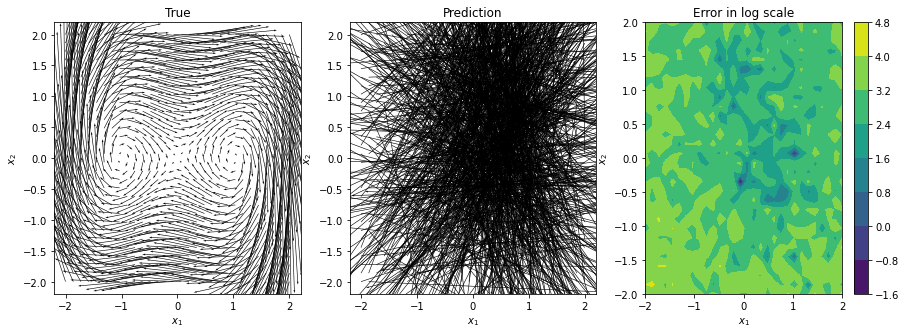

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.quiver(xv,yv, Flow[:,:,0], Flow[:,:,1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(xv,yv, Flow_pred[:,:,0], Flow_pred[:,:,1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(xv, yv, np.log(np.linalg.norm(Flow - Flow_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

### Continuous in time case

Considering $x_r$ as the observation of a state at time $t$, and $x_{r+1}$ the state at time $t+ \Delta t$, for $\Delta t \rightarrow 0$  it is also possible to define the continuous-time infinitesimal generator of the Koopman operator family as

$$
\mathcal{L} g (x_t)  = \lim_{\Delta t \rightarrow 0} \frac{\mathcal{K}g(x_t)- g(x_{t})}{\Delta t} = \frac{g \circ\mathbf{F} (x_t) -x_t}{\Delta t}
$$

The pevious expression defines the Lie derivative, and for this reason $\mathcal{L}$ is known as the Lie operator. $\mathcal{L}$ describes the continuous dynamics of the observables in the Koopman space:

$$
\dot{g} (x) = \mathcal{L} g(x).
$$

The latter can be further expressed as:

$$
\dot{g} (x(t)) = \frac{dg(x)}{dt} = \nabla_x g \frac{dx}{dt} = \nabla_x g \cdot f(x) =\mathcal{L} g(x).
$$

Given $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{L}_{\phi}$ three parameterized functions, the following conditions hold:

1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x)) - x  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{L_{\phi}} g_{\theta} ( x ) - \nabla g_{\theta} \cdot f(x)  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{L_{\phi}} g_{\theta} ( x )\right) - f(x) \Vert = 0
     $$

As long as the system $f(x)$ is known, the three errors can be computed without data belonging to trajectories.

In [ ]:
# create dataset for continuous Koopman
# with the same amount of points of the Discontinuous Koopman case
X0 = (np.random.rand(Ninit*(niter-1),2)-0.5)*4
dX =np.zeros(X0.shape)
for i in tqdm(range(X0.shape[0])):
    dX[i,:] = duffing(0,X0[i,:])

100%|██████████| 299940/299940 [00:00<00:00, 450774.35it/s]


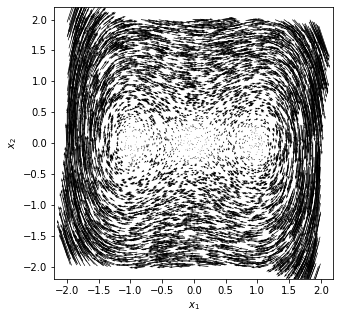

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.quiver(X0[::50,0],X0[::50,1], dX[::50,0]*0.2, dX[::50,1]*0.2, scale=10)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

In [ ]:
# create the models
feature_dim = 2       # dimension of the Duffing oscillator
hidden_layer = 5      # number of hidden layers in g (ENCODER) and \varphi (DECODER)
output_dim = 30       # dimension in Koopman space
batch_size = 2000     # data per batch

In [ ]:
X_train, X_test, Y_train, Y_test =  train_test_split(X0, dX, test_size=0.2)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

training_data = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(Y_test))

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [ ]:
class encoder(nn.Module):
    def __init__(self, layer_dim):
        super(encoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i+1]))

    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [ ]:
class decoder(nn.Module):
    def __init__(self, layer_dim):
        super(decoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1,0,-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i-1]))

    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [ ]:
class autoencoder(nn.Module):
    def __init__(self,feature_dim, hidden_layer, output_dim):
        super(autoencoder, self).__init__()
        layer_dim = [output_dim if i == hidden_layer else feature_dim+i*(output_dim-feature_dim)//hidden_layer for i in range(hidden_layer+1)]
        self.encoder = encoder(layer_dim)
        self.decoder = decoder(layer_dim)
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)

The Lie operator must be defined such that it will be always stable by construction.
To do that, we consider a matrix of parameters $\Psi \in \mathbb{R}^{m \times m}$ and a vector of parameters $\Gamma \in \mathbb{R}^m$. The resulting Lie operator will be of the form:

$$
\mathbf{L} = (\Psi - \Psi^T) - \text{diag}(\vert \Gamma \vert)
$$

with eigenvalues whose real part $\Re(\lambda) \leq 0$ .
See https://math.stackexchange.com/questions/952233/eigenvalues-of-the-sum-of-a-diagonal-matrix-and-a-skew-symmetric-matrix for the mathematical proof. Moreover if $\lambda \in \mathbb{C}$ is an eigenvalue of $\mathbf{L}$, it turns out that its real part $\Re(\lambda) \propto \Vert \Gamma \Vert$, i.e. it only depends on $\Gamma$. Minimizing the $\Vert \cdot \Vert_{\infty}$ norm, we can force just a few modes to be on the $\Re(\lambda) =0$ axes.



**Question 4.** : As you did for the discrete case, you now have to implement the `LieModule` module. It should have the form indicated above to guarantee $\Re(\lambda) \leq 0$. Check that the initialization fulfills this property.

In [ ]:
# custom nn.Linear to recover the Lie operator
class LieModule(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.weight = torch.nn.Parameter(torch.randn(output_dim, output_dim))
        self.diagonal = torch.nn.Parameter(torch.randn(output_dim)) # To be Implemented
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))

    def forward(self, X):
        x, y = X.shape
        if x != self.output_dim and y != self.output_dim:
            sys.exit(f'Wrong Input Features. Please use tensor with {self.output_dim} Input Features')
        ## To be Implemented

        lie_operator = self.weight - self.weight.t() - torch.diag(torch.abs(self.diagonal))

        return torch.matmul(X, lie_operator),lie_operator

In [ ]:
# start training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
AUTOENCODER = autoencoder(feature_dim, hidden_layer, output_dim).to(device)
LIE = LieModule(output_dim).to(device)
print(AUTOENCODER)

autoencoder(
  (encoder): encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


Some tricks are needed to train. If the autoencoder and the Lie model are learned at the same speed, the training turns out to be highly unstable since the three loss functions have moving targets. For this reason, the Lie learning rate has been chosen smaller than the autoencoder one.

In [ ]:
opt_aut = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.0001, weight_decay=1e-3)
opt_lie = torch.optim.Adam(LIE.parameters(), lr=0.00001, weight_decay=1e-3)

A further loss is considered to stabilize the learning stage. The state $x$ belongs to a compact set, since it is the solution of a dissipative dynamical system. This is not true for $g(x)$ (we need to choose appropriate activation functions to have appropriate Liptchitz guarantees). To avoid discrepancies in magnitudes of $g_i(x)$, a regularization loss is added:

$$
\mu = \frac{1}{m} \sum_m g_i(x) = 0  \quad \text{and} \quad  \sigma = \left( \frac{1}{m}\sum_m(g_i(x)-\mu)^2 \right)^{1/2} = 1
$$

inspired by VAE.

For the training to be smooth, the encoder parameters are not affected by the **prediction loss in phase space**. This is based on an empirical observation and is motivated by the fact that the encoder appears in the three losses and plays a competitive role against the decoder and the Lie model. This should not affect the results since the encoder remains coupled with the decoder in the **reconstruction loss** and with the Lie operator in the **prediction loss in Koopman space**.

**Question 5.** : Implement the loss function similarly to what you did for the **Question 2.**

In [ ]:
def LOSS(X_, dX, gX, dgX, X_recon, dX_recon, jvp):
    mse_loss = nn.MSELoss()

    # Reconstruction error
    loss_reconstruction = mse_loss(X_recon, X_)# X_recon = in_observable(observable(X_))=phi(g(x))

    # Prediction error in Koopman space
    loss_koopman_prediction = mse_loss(dgX, jvp)# dgX = LIE*gX jvp = \nabla g * f(X_)

    # Prediction error in the phase space
    loss_phase_prediction = mse_loss(dX_recon, dX) #dX=f(x) dX_recon=phi(LIE*g(X))

    # Regularization losses
    mu = torch.mean(gX, dim=0)
    sigma = torch.mean((gX - mu) ** 2).sqrt()
    loss_mu_regularization = mse_loss(mu, torch.tensor([0.0]).to(device))
    loss_sigma_regularization = mse_loss(sigma, torch.tensor([1.0]).to(device))

    total_loss = (
        loss_reconstruction +
        loss_koopman_prediction +
        loss_phase_prediction +
        loss_mu_regularization +
        loss_sigma_regularization
    )

    return total_loss

Since trajectories are not needed, random states can be sampled from the system manifold $x_1 \in [-2, 2]$, $x_2 \in [-2, 2]$ (see previous figure).

In [ ]:
def training_lie():
    for epoch in range(100):
        AUTOENCODER.train()
        LIE.train()
        total_train_loss = 0
        total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
        for X_, dX_ in train_dataloader:
            X_, dX_ = X_.to(device), dX_.to(device)

            opt_aut.zero_grad()
            opt_lie.zero_grad()

            # dgX = LIE*gX
            # jvp = \nabla g * f(X_)
            (gX, jvp) = autograd.functional.jvp(AUTOENCODER.encoder,X_,dX_, create_graph=True)
            X_recon = AUTOENCODER.decoder(gX)

            dgX, L = LIE(gX)
            dX_recon = AUTOENCODER.decoder(dgX)

            output = LOSS(X_, dX_, gX, dgX, X_recon, dX_recon, jvp)
            output.backward()
            opt_aut.step()
            opt_lie.step()

            if epoch%1 == 0:
                total_train_loss += output.item()/X_.size(0)/len(train_dataloader)
        if epoch%1 == 0:

            print(epoch, total_train_loss)

        if epoch%10 == 0:
            AUTOENCODER.eval()
            LIE.eval()
            with torch.no_grad():
                total_test_loss = 0
                total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
                for X_, dX_ in test_dataloader:
                    X_, dX_ = X_.to(device), dX_.to(device)

                    (gX, jvp) = autograd.functional.jvp(AUTOENCODER.encoder,X_,dX_, create_graph=True)
                    X_recon = AUTOENCODER.decoder(gX)

                    dgX, L = LIE(gX)
                    dX_recon = AUTOENCODER.decoder(dgX)

                    output = LOSS(X_, dX_, gX, dgX, X_recon, dX_recon, jvp)
                    total_test_loss += output.item()/X_.size(0)/len(test_dataloader)
                print('-'*50, 'TEST', '-'*50)
                if (epoch != 0):
                    epoch_list.append(epoch)
                    test_loss.append(total_test_loss)
                print(epoch, total_test_loss)

                print('-'*106)

In [ ]:
test_loss=[]
epoch_list=[]
training_lie()

0 0.002605641760362796
-------------------------------------------------- TEST --------------------------------------------------
0 0.0025363937953219273
----------------------------------------------------------------------------------------------------------
1 0.002438944057135148
2 0.00209954822678817
3 0.0015990037841251432
4 0.001192206628348628
5 0.0010417758454033352
6 0.0009519907133682462
7 0.0008821850600100129
8 0.0008260128227116012
9 0.0007811437624013701
10 0.0007418743129017977
-------------------------------------------------- TEST --------------------------------------------------
10 0.0007201241906961696
----------------------------------------------------------------------------------------------------------
11 0.0007011268907377642
12 0.0006486827339950296
13 0.0005574714523286959
14 0.00042962693455252164
15 0.0003604090214545225
16 0.00032062086826927427
17 0.00029139273462417423
18 0.00026785557061754996
19 0.0002480807867967718
20 0.00023136792799092112
--------

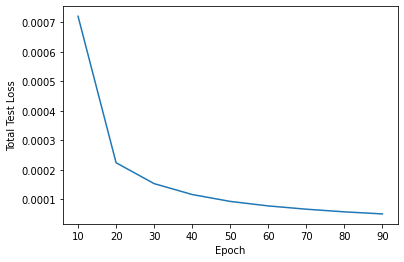

In [ ]:
# Plot to visualize the evaluation of total test loss with epochs
plt.plot(epoch_list,test_loss)
plt.ylabel('Total Test Loss')
plt.xlabel('Epoch')
plt.show()

The above plot shows that the total test loss decreases with the number of epochs.

### Verification

**Question 6.** : As in the **Question 3.** we want to ensure the Lie operator is stable. This can be verified by checking that the real part of the eigenvalues is negative. Plot the relevant eigenvalues of the Lie operator. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

The Lie operator is stable.


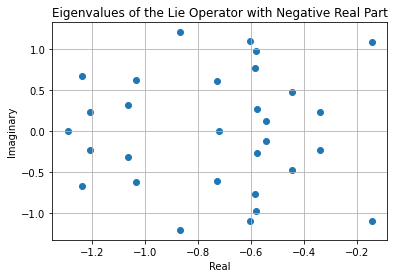

In [ ]:
#check LIE stability
# To Be Implemented
# Extract the Lie operator matrix L from the LIE model
L_matrix = L.cpu().detach().numpy()

# Calculate the eigenvalues
eigenvalues = np.linalg.eigvals(L_matrix)
real_eigenvalues =np.real(eigenvalues)

#  Checking that the real part of the eigenvalues is negative.
if np.all(real_eigenvalues < 0):
    print("The Lie operator is stable.")
else:
    print("The Lie operator is not stable.")
# Plot the eigenvalues
plt.scatter(real_eigenvalues, np.imag(eigenvalues))
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Eigenvalues of the Lie Operator with Negative Real Part')
plt.grid(True)
plt.show()

In [ ]:
def DUFFING(x : np.ndarray) -> np.ndarray:
    dx = np.zeros(x.shape)
    dx[0] = x[1]
    dx[1] = x[0] -x[0]**3
    return dx

N = 30
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, y)

Flow = np.zeros((N,N,2))

for i in range(N):
    for j in range(N):
        Flow[i,j,:] = DUFFING(np.array([xv[i,j],yv[i,j]]))

AUTOENCODER.eval()
LIE.eval()
Flow_pred = np.zeros((N,N,2))
for i in range(N):
    for j in range(N):
        Flow_pred[i,j,:] =  AUTOENCODER.decoder(
                            torch.matmul(
                            AUTOENCODER.encoder(torch.from_numpy(np.array([[xv[i,j],yv[i,j]]])).to(device)), L.t())
                            ).detach().cpu().numpy()


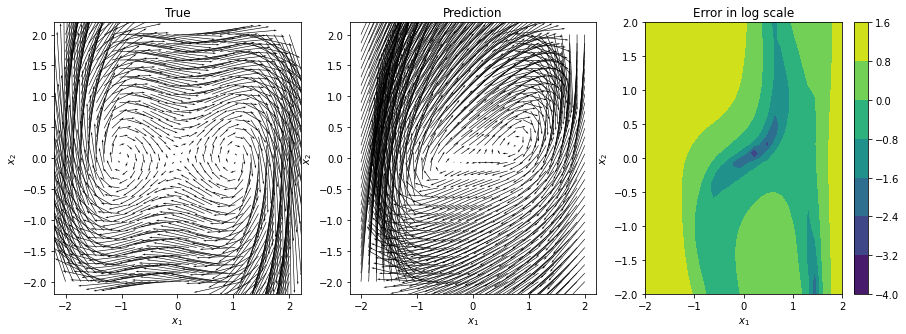

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.quiver(xv,yv, Flow[:,:,0], Flow[:,:,1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(xv,yv, Flow_pred[:,:,0], Flow_pred[:,:,1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(xv, yv, np.log(np.linalg.norm(Flow - Flow_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

**Question 7.** : Compare and comment below the two approaches.


Both the Koopman operator and the Lie operator are mathematical tools used in the analysis of dynamical systems, but they operate in different spaces and serve different functions.

**Koopman Operator:** The Koopman operator is a linear operator that acts on functions defined on the state space of a dynamical system. It describes how these functions evolve over time as the system evolves along its trajectories. The Koopman operator is useful for analyzing a dynamical system's long-term behavior, such as its stability, oscillations, and bifurcations. It is particularly useful for analyzing nonlinear systems, as it provides a linear representation of the dynamics of the system.

In the **first** approach, we wanted the total test  loss to be minimized, which includes the three loss terms, namely reconstruction error, prediction error in Koopman space, and prediction error in phase space. The loss components were weighted by four hyperparameters, alpha, beta, gamma, and delta, which control the relative importance of each term. To balance the importance of each loss component, we had adjusted the values of the hyperparameters alpha, beta, gamma, and delta. If one loss component was more important than the others, its corresponding hyperparameter was increased, while the others were decreased proportionally, to arrive at good hyperparameters.

Regarding the scales of the different losses, they depend on the nature of the data and the specific task at hand. Therefore, it is essential to choose appropriate values for the hyperparameters that balance the importance of the different objectives.

In the **second** approach, to improve the training process, we refined the loss acting upon the latent space using a variational autoencoder approach. We included a corresponding loss for the latent space, which ensured that the prediction in the latent space (i.e., the Koopman space) was a normal distribution N(0,1). The additional term penalized the deviation of the predicted distribution from the standard normal distribution. The difference to 0 mean and 1 standard deviation was included in the loss.

In addition to the above two methods, we can also freeze the gradients of one part of the network, for instance, the encoder, for one specific objective, using the requires_grad property. This technique is useful when we want to train part of the network to solve a specific task without affecting the other parts.


**Lie Operator:** The Lie operator, also known as the Lie derivative, is a differential operator that acts on vector fields defined on a manifold. It describes the rate of change of one vector field along the flow generated by another. In other words, it determines how a vector field changes as it travels along the flow of another vector field. The Lie operator is often used to study the geometric properties of dynamical systems, such as the curvature of trajectories.
In our implementation, the lie operator was used to calculate the Jacobian vector product (JVP) of the encoder function with respect to the input data. The JVP was then used to compute the prediction error in Koopman space, which was calculated using the mean squared error (MSE) loss function.The LieOperator class implemented the lie operator for a given dynamical system, and was used to compute the Koopman operator and its eigenvectors. The reconstruction error in phase space was then calculated using the MSE loss function. In addition to the prediction errors, the code also included regularization losses for the mean and standard deviation of the output of the encoder function, gX. These regularization losses were also calculated using the MSE loss function. The total loss function was then calculated as the sum of the reconstruction, prediction, and regularization losses.

**Observations:** The predictions from the implemented Lie operator in continuous space seems more close to the true values than the implemented Koopman operator in discrete space.
